# Hrátky s diskrétní Fourierovou transformací: grafika

*Tomáš Kalvoda, KAM FIT ČVUT, 2015*

Tento notebook obsahuje jednoduché ukázky využití diskrétní Fourierovy transformace při úpravách obrázků. Stručně předvedeme, jak pomocí konvolučního operátoru rozmazávat obrázky a detekovat hrany v obrázku. K prakticky použitelné implementaci konvoluce využijeme rychlou Fourierovu transformaci.

## Pomocné funkce

In [1]:
# balíček pro vykreslování grafů
using Winston

In [2]:
# Gaussovské vyhlazovací jádro
function gaussk(n::Int, a::Real)
    nhalf = floor(Int, n/2)
    # Předpočteme hodnoty exponenciály...
    tmp = [
        Float64[exp(-k^2/a) for k in 0:nhalf-1],
        Float64[exp(-(n-k)^2/a) for k in nhalf:n-1]
    ]
    # ...a znormalizujeme součet.
    return 1/sum(tmp)*tmp
end

gaussk (generic function with 1 method)

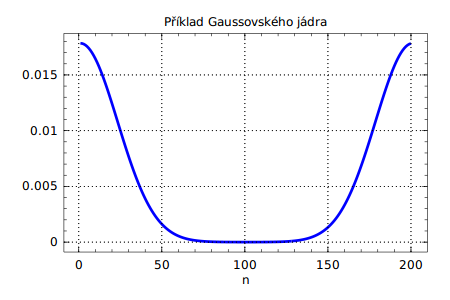

In [3]:
p = FramedPlot(
    title="Příklad Gaussovského jádra",
    xlabel="n"
)
setattr(p.frame, draw_grid=true)
add(p, Curve(1:200, gaussk(200,1000), color="blue", linewidth=7))

Připomeňme, že vektory $x\in\mathbb{C}^N$ chápeme jako periodicky oboustranně prodloužené do nekonečna.

In [6]:
# výpočet konvoluce pomocí DFT, resp. FFT
convolve(x::Vector{Float64}, y::Vector{Float64}) = real(ifft(fft(x) .* fft(y)))

convolve (generic function with 1 method)

Efekt rozmazání si otestujeme na po částech konstantních datech.

In [7]:
test = [zeros(50), ones(100), 0.5*ones(50), zeros(50)];

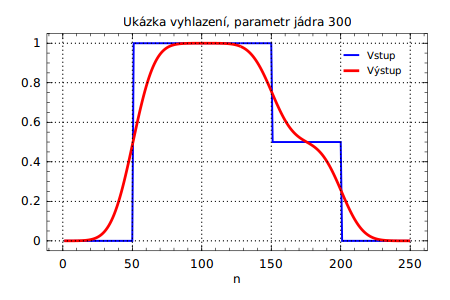

In [8]:
a = 300
p = FramedPlot(
    title="Ukázka vyhlazení, parametr jádra $a",
    xlabel="n"
)
setattr(p.frame, draw_grid=true)
figin = Curve(1:length(test), test, color="blue", linewidth=5)
setattr(figin, label="Vstup")
figout = Curve(1:length(test), convolve(test,gaussk(length(test),a)), color="red", linewidth=7)
setattr(figout, label="Výstup")
leg = Legend(.8, .9, {figin, figout})
add(p, figin, figout, leg)

## Gaussovské rozmazání (*Gaussian blur*)

In [9]:
using Images, Color, FixedPointNumbers

Co jiného můžeme použít k demonstraci vyhlazování než portrét J.C.F. Gausse.

In [10]:
picgauss = imread("johann_carl_friedrich_gauss.jpg");
show(picgauss)

RGB Image with:
  data: 299x349 Array{RGB{UfixedBase{Uint8,8}},2}
  properties:
    IMcs: sRGB
    spatialorder:  x y
    pixelspacing:  1 1

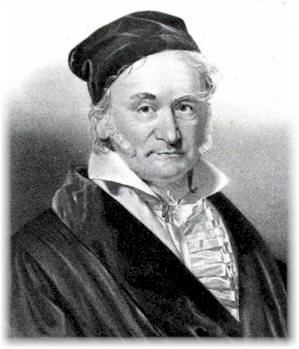

In [11]:
picgauss

Jedná se o černobílý obrázek, stačí pracovat jen s jedním kanálem, třeba zeleným. Naše úpravy tedy budeme provádět s maticí odstínů šedi, která je vyjádřena číslem z intervalu $(0,1)$.

In [13]:
datagauss = map(x->convert(Float64,x.r), data(picgauss))

299x349 Array{Float64,2}:
 0.992157  0.988235  0.988235  0.992157  …  1.0       1.0       1.0     
 0.988235  0.992157  0.992157  0.996078     1.0       1.0       1.0     
 0.988235  0.996078  1.0       1.0          0.996078  1.0       1.0     
 0.984314  1.0       1.0       1.0          0.988235  0.996078  1.0     
 0.988235  1.0       1.0       1.0          0.980392  0.992157  0.996078
 0.992157  1.0       1.0       1.0       …  0.972549  0.992157  0.996078
 1.0       1.0       1.0       1.0          0.968627  0.988235  0.996078
 1.0       0.996078  0.992157  0.996078     0.964706  0.988235  0.996078
 0.996078  0.996078  0.996078  0.996078     0.960784  0.988235  0.996078
 0.996078  0.996078  0.996078  0.996078     0.956863  0.984314  0.996078
 0.996078  0.996078  0.996078  0.996078  …  0.952941  0.984314  0.996078
 0.996078  0.996078  0.996078  0.996078     0.94902   0.980392  0.992157
 0.996078  0.996078  0.996078  0.996078     0.94902   0.984314  0.996078
 ⋮                       

Gaussovské rozmazání implementuje následující funkce.

In [14]:
function gauss_blur(pic::Array{Float64,2}, a::Real)
    # místo pro výsledek (matice tvořená
    # nulami se stejným rozměrem jako pic)
    tmp = zeros(pic)
    # počet řádků a sloupců
    nrows, ncols = size(tmp)
    # rozmázneme každý sloupec (Julia uchovává
    # matice po sloupcích - column-major order).
    for k in 1:ncols
        tmp[:,k] = convolve(pic[:,k], gaussk(nrows, a))
    end
    return tmp
end

gauss_blur (generic function with 1 method)

Vodorovné rozmazávání.

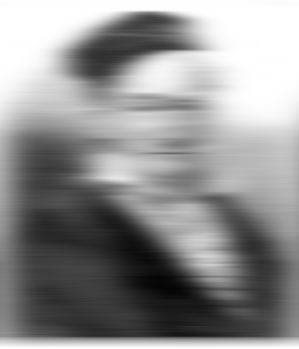

In [17]:
newgauss = gauss_blur(datagauss, 500);
imwrite(newgauss,"johann_carl_friedrich_gauss_h.jpg")
copyproperties(picgauss, map(x->RGB(x,x,x), newgauss))

Svislé rozmazávání získáme rozmazáním transponované matice a její zpětnou transpozicí.

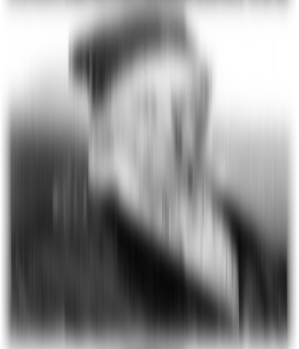

In [18]:
newgauss = transpose(gauss_blur(transpose(datagauss), 500));
imwrite(newgauss,"johann_carl_friedrich_gauss_v.jpg")
copyproperties(picgauss, map(x->RGB(x,x,x), newgauss))

Pokud aplikujeme obě operace postupně, získáme pěkné Gaussovské rozmazání.

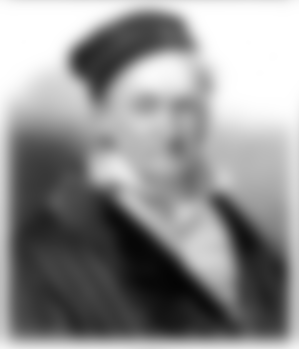

In [19]:
newgauss = gauss_blur(transpose(gauss_blur(transpose(datagauss), 100)),100);
imwrite(newgauss,"johann_carl_friedrich_gauss_blur.jpg")
copyproperties(picgauss, map(x->RGB(x,x,x), newgauss))

## Detekce hran

Pomocí konvolučního filtru lze v obrázku detekovat hrany, či ostré přechody. K tomu slouží jádro, které získáme derivací Gaussovského.

In [7]:
# jádro pro detekci hran: derivace Gaussovského
function dgaussk(n::Int, a::Real)
    nhalf = floor(Int, n/2)
    # Předpočteme hodnoty exponenciály...
    tmp = [
        Float64[-2*k/a^(3/2)*exp(-k^2/a) for k in 0:nhalf-1],
        Float64[2*(n-k)/a^(3/2)*exp(-(n-k)^2/a) for k in nhalf:n-1]
    ]
    return tmp
end

dgaussk (generic function with 1 method)

Jeho průběh je znázorněn níže.

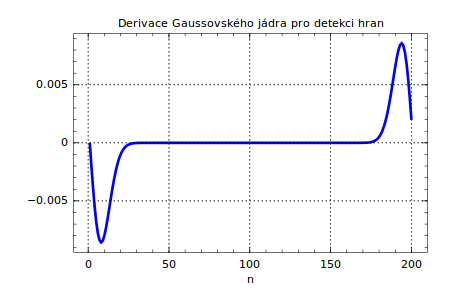

In [140]:
p = FramedPlot(
title="Derivace Gaussovského jádra pro detekci hran",
    xlabel="n"
)
setattr(p.frame, draw_grid=true)
add(p, Curve(1:200, dgaussk(200,100), color="blue", linewidth=7))

Funkce pro detekci hran.

In [8]:
function edges(pic::Array{Float64,2}, a::Real)
    # místo pro výsledek (matice tvořená
    # nulami se stejným rozměrem jako pic)
    tmp = zeros(pic)
    # počet řádků a sloupců
    nrows, ncols = size(tmp)
    # rozmázneme každý sloupec (Julia uchovává
    # matice po sloupcích - column-major order).
    for k in 1:ncols
        tmp[:,k] = convolve(pic[:,k], dgaussk(nrows, a))
    end
    return tmp
end

edges (generic function with 1 method)

Ukázka výsledku.

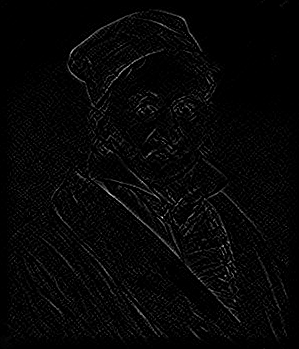

In [149]:
newgauss = edges(transpose(edges(transpose(datagauss), .5)), .5);
copyproperties(picgauss, map(x->RGB(x,x,x), 1/maximum(newgauss)*newgauss))